## Inputs

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import cv2 as cv
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchsummary import summary
import nibabel as nib
from tqdm import tqdm

print('imported')

imported


### Loading data: MRI images

In [3]:
# constants
base_directory = './Brats_only_lesion_max_ROI/'
train_patient_list = os.listdir(base_directory + 'train/')
test_patient_list = os.listdir(base_directory + 'test/')

# Je prend la moitié seulement, pour attendre les 50k images pour train et ~10k pour le test
train_patient_list = train_patient_list[: len(train_patient_list) // 2]
test_patient_list = test_patient_list[: len(test_patient_list) // 2]

slices_per_patient = 96
num_slices_selected = 3

In [4]:
class BratsDataset(Dataset):
    def __init__(self, mode, transform=None):
        super(BratsDataset, self).__init__()
        self.mode = mode
        self.transform = transform
        self.patient_list = train_patient_list if mode == 'train' else test_patient_list
        self.directory = base_directory + mode + '/'

        self.x = []
        for patient in tqdm(self.patient_list):
            self.x.append(nib.load(self.directory + patient + '/' + patient + '_t1.nii.gz').get_fdata())
        self.x = np.stack(self.x, axis=0)

    def __len__(self):
        return len(self.patient_list) 

    def get_data(self):
        return self.x

    def __getitem__(self, idx):
        
        # idx est l'index du patient
        query = self.x[idx]
        slices_selected = np.random.choice(query.shape[-1], num_slices_selected)
        # on prend les 3 slices
        query = query[:, :, slices_selected]

        slices_selected = np.random.choice(query.shape[-1], num_slices_selected)   
        # on prend les 3 slices
        relevant = query[:, :, slices_selected]     

        irrelevant_idx = None
        while irrelevant_idx is None or irrelevant_idx == idx: 
            # on selectionne un patient différent au hasard
            irrelevant_idx = np.random.randint(0, len(self.patient_list))

        irrelevant = self.x[irrelevant_idx]
        slices_selected = np.random.choice(irrelevant.shape[-1], num_slices_selected)
        irrelevant = irrelevant[:, :, slices_selected]

        query = torch.Tensor(cv.normalize(query.transpose(2, 0, 1), None, 0, 1, cv.NORM_MINMAX))
        relevant = torch.Tensor(cv.normalize(relevant.transpose(2, 0, 1), None, 0, 1, cv.NORM_MINMAX))
        irrelevant = torch.Tensor(cv.normalize(irrelevant.transpose(2, 0, 1), None, 0, 1, cv.NORM_MINMAX))

        # on normalise les images
        if self.transform:
            query = self.transform(query)
            relevant = self.transform(relevant)
            irrelevant = self.transform(irrelevant)

        return query, relevant, irrelevant

In [5]:
train_dataset = BratsDataset('train', transform=None)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 525/525 [00:52<00:00, 10.09it/s]


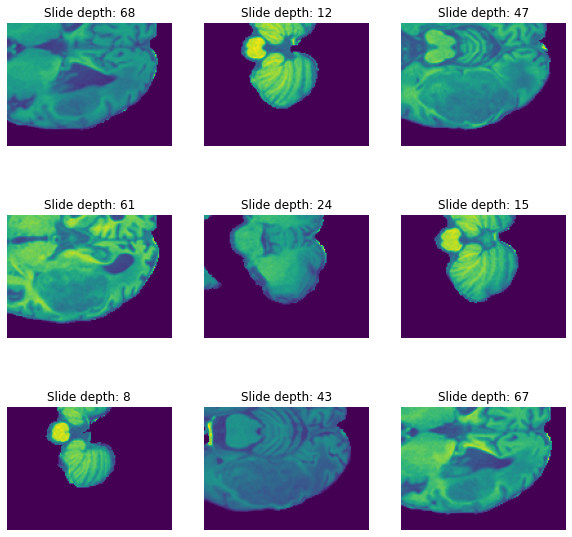

In [163]:
idx = np.random.randint(0, len(train_patient_list))
example_sample = nib.load(base_directory + 'train/' + train_patient_list[idx] + '/' + train_patient_list[idx] + '_t1.nii.gz')
example_sample = example_sample.get_fdata()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    slide_depth = np.random.randint(0, 96)
    plt.imshow(example_sample[:, :, slide_depth])
    plt.axis('off')
    plt.title('Slide depth: ' + str(slide_depth))
plt.show()

## Defininf the model

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [283]:
class SiameseEncoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(SiameseEncoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.Flatten(),
            nn.Linear(in_features=256 * 3 * 4, out_features=latent_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

    def train_for_cbir(self, train_loader, epoch=10, lr=0.001):
        # training constants
        self.train()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)

        # traing
        # an epoch is equivalent to 96 times the train_loader loop
        for epoch in range(epoch * 96):
            for batch_idx, (query, relevant, irrelevant) in enumerate(train_loader):
                query = query.to(device, dtype=torch.float)
                relevant, irrelevant = relevant.to(device, dtype=torch.float), irrelevant.to(device, dtype=torch.float)
                optimizer.zero_grad()
                query_latent = self.forward(query)
                relevant_latent = self.forward(relevant)
                irrelevant_latent = self.forward(irrelevant)
                loss = triplet_loss(query_latent, relevant_latent, irrelevant_latent)
                loss.backward()
                optimizer.step()
                if batch_idx == 8:
                    print('Train Epoch: {} --\tLoss: {:.6f}'.format((epoch // 96), loss.item()))
                    

## Training

In [284]:
model = SiameseEncoder(latent_dim=256).to(device, dtype=torch.float)
summary(model, (3, 96, 128))
# model.train_for_cbir(train_loader, epoch=5, lr=0.001)

Train Epoch: 0 --	Loss: 0.000000
Train Epoch: 0 --	Loss: 0.000000
Train Epoch: 0 --	Loss: 0.000000
Train Epoch: 0 --	Loss: 0.000000
Train Epoch: 0 --	Loss: 0.000000
Train Epoch: 0 --	Loss: 0.000000
Train Epoch: 0 --	Loss: 0.000000
Train Epoch: 0 --	Loss: 0.325056
Train Epoch: 0 --	Loss: 0.347640
Train Epoch: 0 --	Loss: 0.000000
Train Epoch: 0 --	Loss: 0.000000
Train Epoch: 0 --	Loss: 0.000000
Train Epoch: 0 --	Loss: 0.000000
Train Epoch: 0 --	Loss: 0.000000


KeyboardInterrupt: 

In [285]:
x_test = next(iter(train_loader))
q, r, i = x_test[0].to(device, dtype=torch.float), x_test[1].to(device, dtype=torch.float), x_test[2].to(device, dtype=torch.float)
q.shape, r.shape, i.shape

(torch.Size([64, 3, 96, 128]),
 torch.Size([64, 3, 96, 128]),
 torch.Size([64, 3, 96, 128]))

In [286]:
q_latent = model.forward(q)
r_latent = model.forward(r)
i_latent = model.forward(i)

q_latent.shape, r_latent.shape, i_latent.shape

(torch.Size([64, 256]), torch.Size([64, 256]), torch.Size([64, 256]))

In [287]:
nn.TripletMarginLoss(margin=1.0, p=2)(q_latent, r_latent, i_latent).item()

0.44998130202293396

In [257]:
torch.Tensor([torch.dot(q_lat, r_lat) for q_lat, r_lat in zip(q_latent, r_latent)])

tensor([1392.4319, 1205.5244, 3973.3088, 2645.8965, 1936.9301, 1449.3220,
        2037.6313, 1302.3485,  782.7100,  814.8993, 2174.8350,  963.6409,
        2764.4639, 1821.6405, 2664.9517, 2560.7124,  660.5847, 1701.6719,
        2991.8760, 2937.0952, 1335.8499, 1101.2252, 3082.2327, 2400.7344,
        1301.4042, 1081.6758,  585.4669, 1627.0479, 1925.3195, 2366.5071,
        1163.3820, 1318.0212, 4572.5410,  839.9048, 1251.8679, 2066.2329,
        2280.9827, 2370.1960, 1852.1227, 2673.6719, 1869.9689, 1946.7874,
        4098.6338, 1667.5607, 1657.8099, 3842.3936, 2442.0923, 1227.2925,
        1103.4662, 2321.7705,  966.4651, 3344.4426, 1927.6050,  177.6360,
        2067.0435, 3636.3108, 2483.5181,  930.2987,  316.5157, 1655.3209,
        1158.4354, 2564.9407, 2433.3374, 1526.6965])

In [258]:
torch.Tensor([torch.dot(q_lat, i_lat) for q_lat, i_lat in zip(q_latent, i_latent)])

tensor([-1311.9585,  2512.9250,  2446.8242,  1864.8738,  1557.3804,   617.1588,
         -881.8162,   689.9394, -1186.5962,  -417.9570,   714.8071, -1042.0217,
         1824.0635,  2190.6533,  2503.3086,  1616.0964,   525.7308,   674.6895,
           19.1424,   441.7772, -1691.8195,  1287.3922,  1119.4519,  1266.6528,
        -1170.5588,   269.8743,   496.6954,  -922.0117,  1491.9434,   746.4149,
          473.1727,  1730.8157,  1147.8420, -1087.9022,  1926.8805,  1605.8604,
        -1724.6194,  1267.7983,  1258.5883,  1078.5732,   731.8500,   255.6949,
        -1448.5183,   -97.2204,  1341.8223, -2439.1475,   878.0630,   667.4426,
          199.5863,  1452.2698,   286.5725,  2428.3931, -1174.7008,  -130.6492,
        -1261.1414,   629.0694, -2634.2168,   184.1185,   134.6479, -1221.5846,
        -1183.4346,  2293.8792, -1504.4661,  1942.8102])